# Deep neural Network

## GAN

### 2 X 2 images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

ALPHA  = 0.01
EPOCHS = 1000

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [3]:
def fn_polt_samples(samples, m, n):
    
    fig, axes = plt.subplots(figsize = (n*2,m*2),
                            nrows=m, ncols=n,
                            sharey = True, sharex = True) #same axis for all images
    
    axes = axes.flatten()
    
    for ax, img in zip(axes, samples):
        
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)  
        
        im = ax.imshow(1- img.reshape((2,2)), cmap = 'Greys_r')
        
    return fig,axes

In [4]:
## Sigmoid Function

def fn_sigmoid(z):
    return 1/(1.0+np.exp(-z))

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

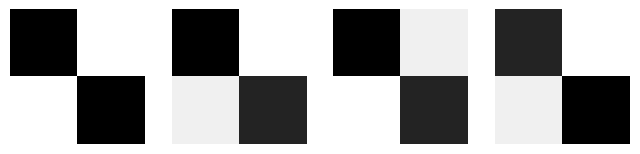

In [5]:
## Example of face

faces = [np.array([1.0,0.0,0.0,1.0]),
         np.array([0.9,0.1,0.2,0.8]),
         np.array([0.9,0.2,0.1,0.8]),
         np.array([0.8,0.1,0.2,0.9]),
         np.array([0.8,0.2,0.1,0.9])]

fn_polt_samples(faces,1,4)

(<Figure size 2000x400 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

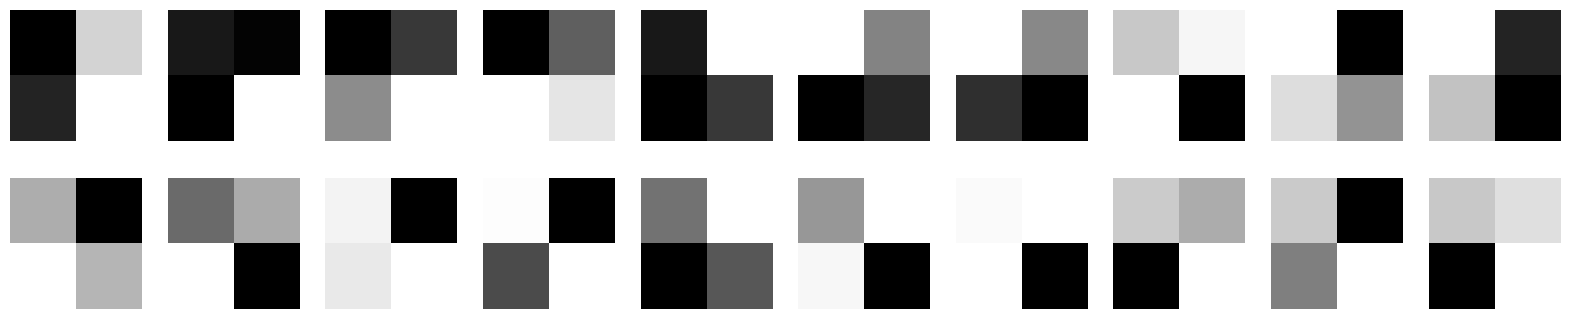

In [6]:
noise = [np.random.random((2,2)).round(2) for i in range(20)]
fn_polt_samples(noise,2,10)

In [7]:
nn_input_dim = 4

# Discriminator class
class Discriminator():
    def __init__(self):
        
        self.weights = np.random.rand(nn_input_dim)/np.sqrt(nn_input_dim)
        self.bias = 0.0
        
    # forward pass
    def forward(self, x):
        return fn_sigmoid(np.dot(x, self.weights)+self.bias)
    
    # Forward calculation error
    def image_error(self, image):
        prediction =  self.forward(image)
        return -np.log(prediction)
    
    def derivatives_from_image(self, image):
        y_pred =  self.forward(image)
        dW = image*(y_pred-1) 
        db = y_pred-1
        return dW, db
    
    # Gradient updates
    def update_from_image(self, x):
        dW, db = self.derivatives_from_image(x)
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db
    
    # Error from noise
    def noise_error(self, noise):
        y_pred = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-y_pred)
    
    def derivatives_from_noise(self, noise):
        y_pred =  self.forward(noise)
        dW = noise*(y_pred) 
        db = y_pred
        return dW, db
    
    # Gradient updates
    def update_from_noise(self, noise):
        dW, db = self.derivatives_from_noise(noise)
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db

In [8]:
# Generator class
class Generator():
    def __init__(self):
        
        self.weights = np.random.rand(nn_input_dim)/np.sqrt(nn_input_dim)
        self.biases = np.zeros(nn_input_dim)
        
    # forward pass
    def forward(self, z):
        return fn_sigmoid(z* self.weights+self.biases)
    
    # Forward calculation error
    def error(self, z, discriminator):
        x =  self.forward(z)
        y =  discriminator.forward(x)
        return -np.log(y)
    
    def derivatives(self, z, discriminator):
        # Get Discriminator weights and biases
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        
        # forward pass of z
        x = self.forward(z) # activations from Generator 
        y = discriminator.forward(x) # activations from Generator submitted to Discriminator
        
        factor = - ( 1 - y ) * discriminator_weights * x *( 1 - x ) # -[ 1 - D(G(z))].W.Gi.(1-Gi)
        dW = factor * z # multiply factor by z
        db = factor
        
        return dW, db
    
    # Update generator weights
    def update(self, z, discriminator):
        
        dW, db = self.derivatives(z, discriminator)
        
        self.weights -= ALPHA * dW
        
        self.biases -= ALPHA * dW
        

In [9]:
# Hyperparameters
learning_rate = ALPHA
epochs = EPOCHS

# Instantiate the GAN
D = Discriminator()
G = Generator()

# Always a good idea to plot the errors
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):
    
    for face in faces:
        
        # Update the discriminator weights from the real face
        D.update_from_image(face)
    
        # Pick a random number to generate a fake face
        z = np.random.rand()

        # Calculate the discriminator error
        errors_discriminator.append(sum(D.image_error(face) + D.noise_error(z)))
        
        # Calculate the generator error
        errors_generator.append(G.error(z, D))
        
        # Build a fake face
        noise = G.forward(z)
        
        # Update the discriminator weights from the fake face
        D.update_from_noise(noise)
    
        # Update the generator weights from the fake face
        G.update(z, D)

In [10]:
generated_images = []
for i in range(100):
    
    z = np.random.random() # generate a random number
    
    generated_image = G.forward(z) # call forward method of Generator class
    
    generated_images.append(generated_image)
    

#for i in generated_images:
#    print(i.round(2))

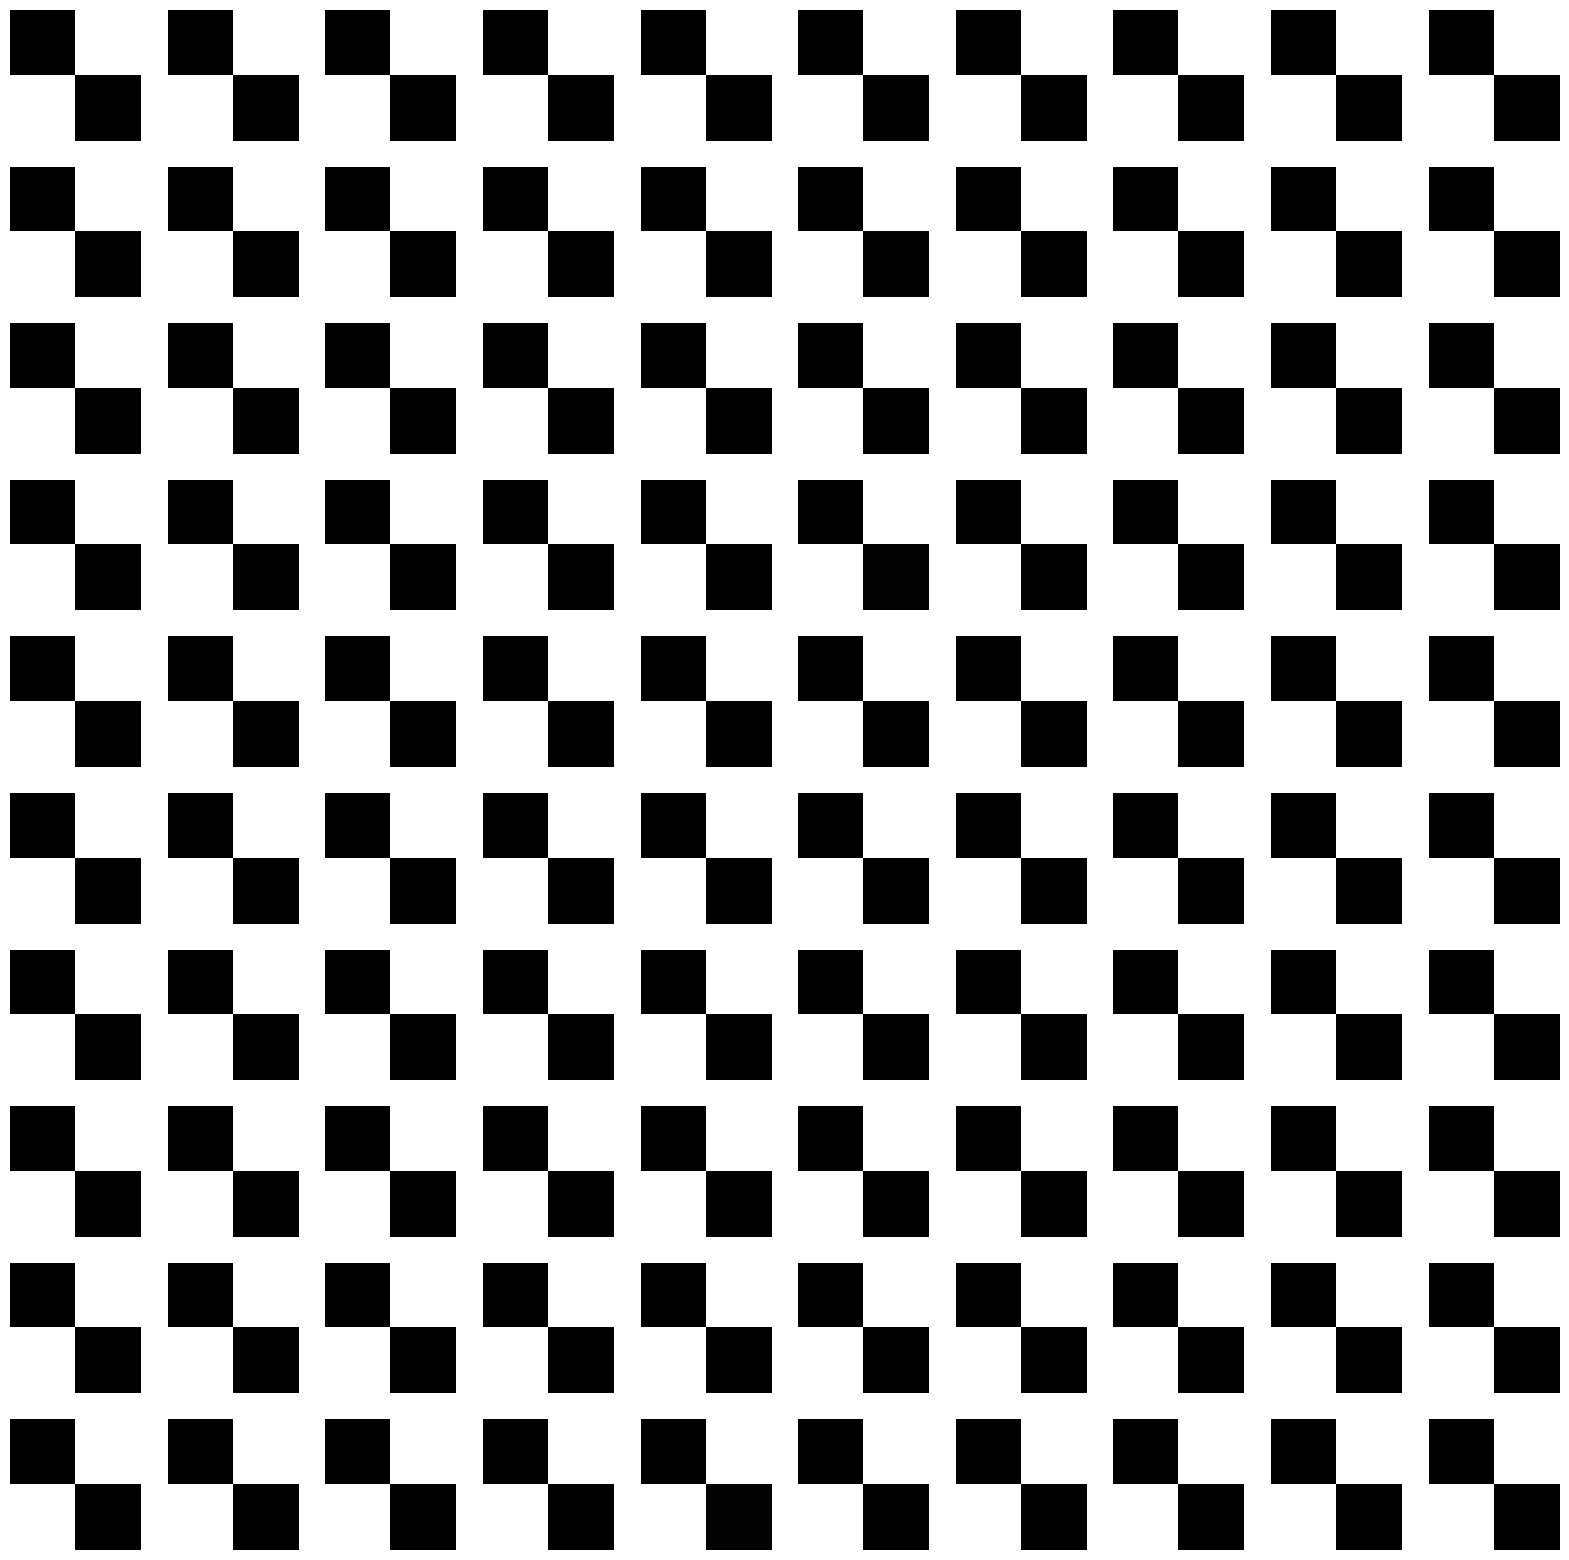

In [13]:
fn_polt_samples(generated_images, 10, 10);